In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

#### data source:

https://finance.yahoo.com/quote/GLD/history?period1=1100754000&period2=1569643200&interval=1d&filter=history&frequency=1d

#### the following website was also helpful:
https://blog.quantinsti.com/build-technical-indicators-in-python/

### Goal of this analysis:
- understand historical and typical behavior of the gold market
- understand gold price correlation to its own indicators and to other markets
- capture major market moves
    - this would generally refer to moves that occur over periods of days, weeks and months
    - this can be done via gold micro and mini futures, GLD options and the GLD stock; both long and short

#### data frame setup

In [2]:
end_date = "2019-11-28"
gld_data = pdr.get_data_yahoo("GLD", start="2004-11-18", end=end_date)
ten_year_note = pdr.get_data_yahoo("^TNX", start="2004-11-19", end=end_date)

In [3]:
ten_year_data = pd.DataFrame(ten_year_note)
df = pd.DataFrame(gld_data)
df.reset_index(level=0, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year

df['intercept'] = 1

In [4]:
last_row = df.iloc[df.shape[0]-1]
print(f'ten_year_data dimensions: {ten_year_data.shape}\n')
print(f'GLD dimensions: {df.shape}')

ten_year_data dimensions: (3777, 6)

GLD dimensions: (3783, 9)


#### in the following sections we add columns showing four week change in nominal, percentage, and categorical  terms

In [5]:
four_week_change = []
for i in range(0, df.shape[0]):
    try:
        a = df['Close'][i] - df['Close'][i-20]
        four_week_change.append(a)
    except:
        four_week_change.append(np.nan)

four_wk_perc_change = []
for i in range(0, df.shape[0]):
    try:
        a = (df['Close'][i] - df['Close'][i-20])/df['Close'][i-20]
        four_wk_perc_change.append(a)
    except:
        four_wk_perc_change.append(np.nan)

df['four_wk_change'] = four_week_change
df['four_wk_perc_change'] = four_wk_perc_change

four_week_indicator = []
for i in df['four_wk_perc_change']:
    if i >= 0.05:
        four_week_indicator.append('large_incr')
    elif i <= -0.05:
        four_week_indicator.append('large_decr')
    else:
        four_week_indicator.append('no_major_change')

df['past_four_weeks'] = four_week_indicator

#### column to show the fifteen-week percentage change

In [6]:
fifteen_wk_perc_change = []
for i in range(0, df.shape[0]):
    try:
        a = (df['Close'][i] - df['Close'][i-75])/df['Close'][i-75]
        fifteen_wk_perc_change.append(a)
    except:
        fifteen_wk_perc_change.append(np.nan)

df['fifteen_wk_perc_change'] = fifteen_wk_perc_change

#### determine 52-week high and low for each row and add column to categorize distance from 52-wk high

In [7]:
df['rolling_52_wk_high'] = df['Close'].rolling(window=52*5, min_periods=1).max()
df['rolling_52_wk_low'] = df['Close'].rolling(window=52*5, min_periods=1).min()

In [8]:
def annual_high_low_category(close, high, low):
    if (high - close) / close <= 0.03:
        return 'at_near_52_wk_high'
    elif (close - low) / close < 0.03:
        return 'at_near_52_wk_low'
    else:
        return 'not_near_high_low'

In [9]:
df['52_wk_status'] = df.apply(lambda row: annual_high_low_category(row['Close'], row['rolling_52_wk_high'], row['rolling_52_wk_low']), axis=1)

#### calculate and categorize distance from 4-week high and low 

In [10]:
df['rolling_4_wk_high'] = df['Close'].rolling(window=20, min_periods=1).max()
df['rolling_4_wk_low'] = df['Close'].rolling(window=20, min_periods=1).min()

In [11]:
def four_week_high_low_category(close, high, low):
    if (high - close) / close <= 0.02:
        return 'at_near_4_wk_high'
    elif (close - low) / close < 0.02:
        return 'at_near_4_wk_low'
    else:
        return 'not_near_high_low'        

In [12]:
df['4_wk_status'] = df.apply(lambda row: four_week_high_low_category(row['Close'], row['rolling_4_wk_high'], row['rolling_4_wk_low']), axis=1)

#### insert columns for 10-day, 50-day and 200-day moving averages - both simple and exponential

In [13]:
df['10_day_simple_MA'] = df['Close'].rolling(window=10, min_periods=1).mean()
df['50_day_simple_MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
df['200_day_simple_MA'] = df['Close'].rolling(window=200, min_periods=1).mean()

df['10_day_exp_MA'] = df['Close'].ewm(span=10).mean()
df['50_day_exp_MA'] = df['Close'].ewm(span=50).mean()
df['200_day_exp_MA'] = df['Close'].ewm(span=200).mean()

df['dist_from_10_day_exp_MA'] = (df['Close'] - df['10_day_exp_MA']) / df['10_day_exp_MA']
df['dist_from_50_day_exp_MA'] = (df['Close'] - df['50_day_exp_MA']) / df['50_day_exp_MA']
df['dist_from_200_day_exp_MA'] = (df['Close'] - df['200_day_exp_MA']) / df['200_day_exp_MA']

In [14]:
fifty_to_ten = []
for i in range(0, df.shape[0]):
    if df['50_day_exp_MA'][i] > df['10_day_exp_MA'][i]:
        fifty_to_ten.append('fifty_day_above_10')
    else:
        fifty_to_ten.append('ten_day_above_exp_50')

df['fifty_to_ten'] = fifty_to_ten

#### columns to show day's range and day's range relative to opening price

this section may need to be updated to show the range relative to the previous day's close so that any gaps up or down can be taken into account

In [15]:
df['day_range'] = df['High'] - df['Low']
df['day_range_perc'] = df['day_range'] / df['Open']

#### in this section we define whether or not gold is in a bull or bear market

#### for the time being this will be determined manually
- the three long-term trend areas will be bull market from start to 2011, then bear through 2015 or 2016, then bull again up through the present
- it is understood that there may be periods in between these dates in which there was a 20+% drop and/or increase; we can analyze that later with other methods

In [16]:
peak2011 = datetime.datetime.strptime('2011-08-22', "%Y-%m-%d")
bottom2015 = datetime.datetime.strptime('2015-12-17', "%Y-%m-%d")

def bull_bear(date):
    if date <= peak2011:
        return 'bull'
    elif peak2011 < date < bottom2015:
        return 'bear'
    else:
        return 'bull'

In [17]:
df['market_type'] = df['Date'].apply(bull_bear)

In [19]:
df['market_type'].value_counts()

bull    2696
bear    1087
Name: market_type, dtype: int64

#### addition of columns to show what happened over the next two weeks and five weeks for each row

In [20]:
two_wk_forward = []
for i in range(0, df.shape[0]):
    try:
        a = (df['Close'][i+10] - df['Close'][i]) / df['Close'][i]
        two_wk_forward.append(a)
    except:
        two_wk_forward.append(np.nan)
df['two_wk_forward_change'] = two_wk_forward

five_wk_forward = []
for i in range(0, df.shape[0]):
    try:
        a = (df['Close'][i+25] - df['Close'][i]) / df['Close'][i]
        five_wk_forward.append(a)
    except:
        five_wk_forward.append(np.nan)
df['five_wk_forward_change'] = five_wk_forward

five_wk_forward_category = []
for i in range(0, df.shape[0]):
    if df['five_wk_forward_change'][i] <= -0.05:
        five_wk_forward_category.append('5_plus_perc_drop')
    elif df['five_wk_forward_change'][i] > 0.05:
        five_wk_forward_category.append('5_plus_perc_incr')
    else:
        five_wk_forward_category.append('no_major_change')
df['five_wk_forward_category'] = five_wk_forward_category

In [21]:
two_and_five_wk = []
for i, j in enumerate(df['Date']):
    if (df['two_wk_forward_change'][i] > 0) and (df['five_wk_forward_change'][i] > 0):
        two_and_five_wk.append(int(1))
    else:
        two_and_five_wk.append(int(0))

df['two_and_five_wk'] = two_and_five_wk

In [22]:
df.groupby(['past_four_weeks', 'five_wk_forward_category'])['intercept'].sum().unstack()

five_wk_forward_category,5_plus_perc_drop,5_plus_perc_incr,no_major_change
past_four_weeks,,,
large_decr,28,120,232
large_incr,127,136,414
no_major_change,279,565,1882


In [23]:
df.query("past_four_weeks == 'large_decr' & five_wk_forward_category == '5_plus_perc_drop'")['Year'].value_counts()

2013    15
2008     7
2006     3
2016     3
Name: Year, dtype: int64

#### Conclusions: 
- In less than ten percent of cases where there has been a five percent drop has the price dropped another five percent lower within the following five weeks.

- All 28 of those cases occurred in the years 2006, 2008, 2013 and 2016.  Those would be explained as follows:
    - The 2006 declines came in mid-2006 after a multi-year run up and parabolic peak
    - The 2008 declines occurred during the financial crisis.  Prices recovered quite quickly.
    - The 2013 declines represented the largest declines of the 2011-2016 bear market.
    - The 2016 declines came at the very end of the bear market.  This is typical price action late in a bear market.

#### Conclusions: 
- Most of the 'five week forward 5% increases' (about 70%) came after a four week period of "no major change"
- The other 5% increases were pretty evenly divided between following a large decrease or a large increase

#### The section below is set up such that for each row the current price is compared to the price in each fo the past 25 days.  If the price has not deviated more than 3% from the current price for the past 25 days then GLD is in a basing pattern.


In [25]:
df['25_day_min'] = df['Close'].rolling(window=26, min_periods=1).min()
df['25_day_max'] = df['Close'].rolling(window=26, min_periods=1).max()

basing_list = [np.nan]*25
for i in range(25, df.shape[0]):
    if (df['Close'][i] - df['25_day_min'][i]) / df['Close'][i] > 0.03:
        basing_list.append('not_in_basing_pattern')
    elif (df['25_day_max'][i] - df['Close'][i]) / df['Close'][i] > 0.03:
        basing_list.append('not_in_basing_pattern')
    else:
        basing_list.append('basing_pattern')

df['base'] = basing_list

In [26]:
df['base'].value_counts()

not_in_basing_pattern    3140
basing_pattern            618
Name: base, dtype: int64

## Basic Graphs - Past to Current
#### Below are several graphs for different short term and long term views of the GLD share price.

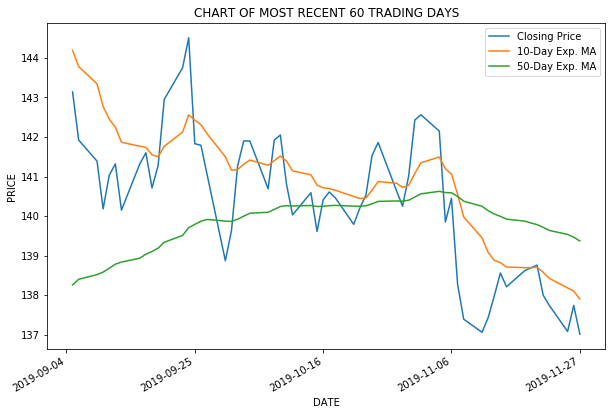

In [78]:
current_date_row = df.shape[0]
sixty_days_prior = df.shape[0] - 60

fig, ax = plt.subplots(figsize=(10, 6))

d = df['Date'][sixty_days_prior:current_date_row]
e = df['Close'][sixty_days_prior:current_date_row]
f = df['10_day_exp_MA'][sixty_days_prior:current_date_row]
g = df['50_day_exp_MA'][sixty_days_prior:current_date_row]
last_row = df.shape[0]-1
x_dates = [df['Date'].dt.date[last_row-60], df['Date'].dt.date[last_row-45], 
           df['Date'].dt.date[last_row-30], df['Date'].dt.date[last_row-15], 
           df['Date'].dt.date[last_row]]

plt.xticks(x_dates, x_dates, rotation=30, ha="right")
ax.set_xlabel('DATE')
ax.set_ylabel('PRICE')
ax.plot(d, e)
ax.plot(d, f)
ax.plot(d, g)
ax.legend(['Closing Price', '10-Day Exp. MA', '50-Day Exp. MA'])
plt.title('CHART OF MOST RECENT 60 TRADING DAYS');

In [29]:
def trend_line(x):
    y1 = -0.10*x + 150
    y2 = -0.10*x + 144
    return y1, y2

trend_points = []
for i in range(0, 90):
    trend_point = trend_line(i)
    trend_points.append(trend_point)

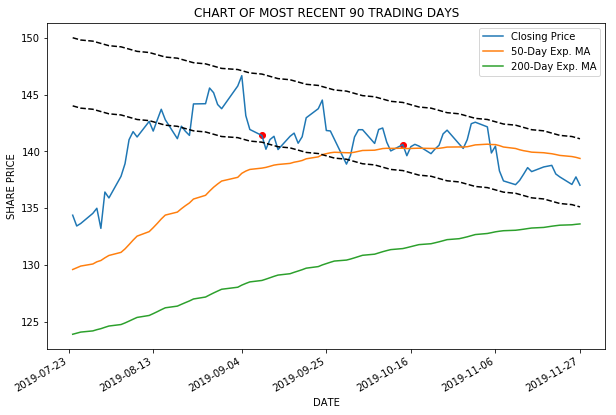

In [30]:
oct14_2019 = int(df[df['Date'] == '2019-10-14'].index.values)

ninety_days_prior = df.shape[0] - 90

fig, ax = plt.subplots(figsize=(10, 6))

d = df['Date'][ninety_days_prior:current_date_row]
e = df['Close'][ninety_days_prior:current_date_row]
f = df['50_day_exp_MA'][ninety_days_prior:current_date_row]
g = df['200_day_exp_MA'][ninety_days_prior:current_date_row]
last_row = df.shape[0]-1
x_dates = []
for i in np.arange(0, 91, 15):
    a = df['Date'].dt.date[last_row-i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation=30, ha="right")
ax.set_xlabel('DATE')
ax.set_ylabel('SHARE PRICE')
ax.plot(d, e)
ax.plot(d, f)
ax.plot(d, g)
ax.plot(d, trend_points, color='black', linestyle='--')
plt.scatter(df['Date'][oct14_2019-25], df['Close'][oct14_2019-25], color='red')
plt.scatter(df['Date'][oct14_2019], df['Close'][oct14_2019], color='red')
plt.title('CHART OF MOST RECENT 90 TRADING DAYS')
plt.legend(['Closing Price', '50-Day Exp. MA', '200-Day Exp. MA']);

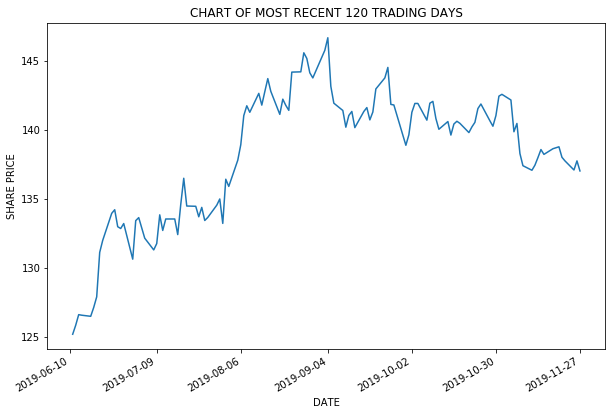

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

d = df['Date'][current_date_row-120:current_date_row]
e = df['Close'][current_date_row-120:current_date_row]
last_row = df.shape[0]-1
x_dates = []
for i in np.arange(0, 121, 20):
    a = df['Date'].dt.date[last_row-i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation=30, ha="right")
ax.set_xlabel('DATE')
ax.set_ylabel('SHARE PRICE')
ax.plot(d, e)
plt.title('CHART OF MOST RECENT 120 TRADING DAYS');

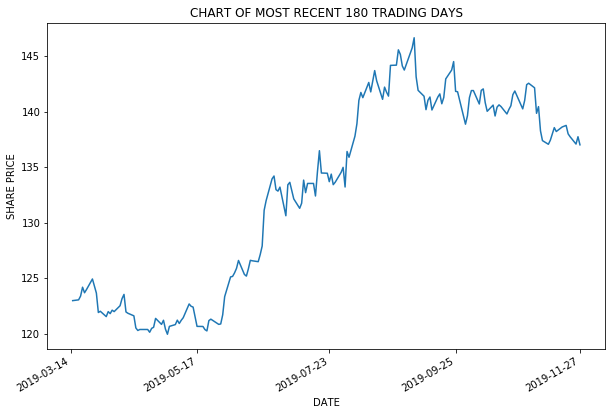

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

d = df['Date'][current_date_row-180:current_date_row]
e = df['Close'][current_date_row-180:current_date_row]
last_row = df.shape[0]-1
x_dates = []
for i in np.arange(0, 181, 45):
    a = df['Date'].dt.date[last_row-i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation=30, ha="right")
ax.set_xlabel('DATE')
ax.set_ylabel('SHARE PRICE')
ax.plot(d, e)
plt.title('CHART OF MOST RECENT 180 TRADING DAYS');

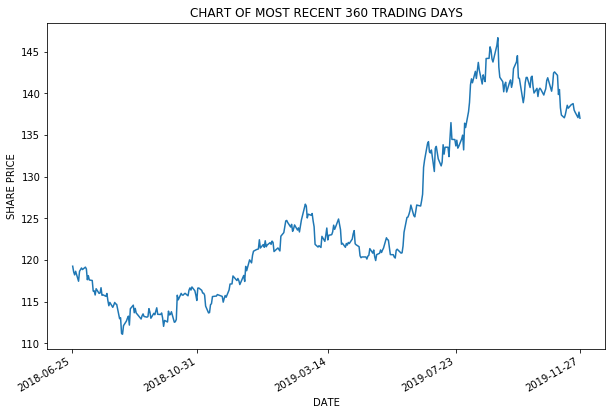

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

d = df['Date'][current_date_row-360:current_date_row]
e = df['Close'][current_date_row-360:current_date_row]
last_row = df.shape[0]-1
x_dates = []
for i in np.arange(0, 361, 90):
    a = df['Date'].dt.date[last_row-i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation=30, ha="right")
ax.set_xlabel('DATE')
ax.set_ylabel('SHARE PRICE')
ax.plot(d, e)
plt.title('CHART OF MOST RECENT 360 TRADING DAYS');

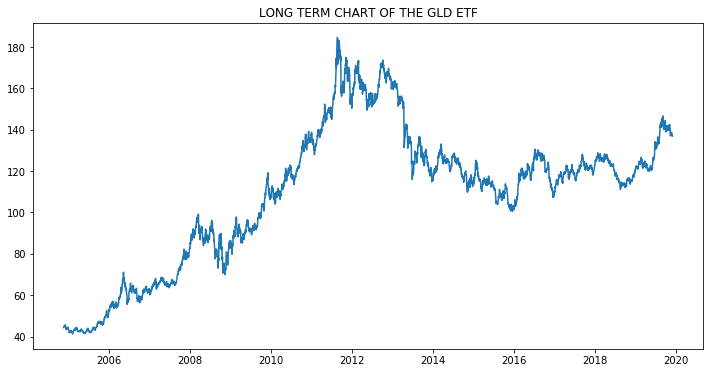

In [35]:
a = df['Date']
b = df['Close']

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(a, b)
plt.title('LONG TERM CHART OF THE GLD ETF');

## Basic Graphs - Specific Periods

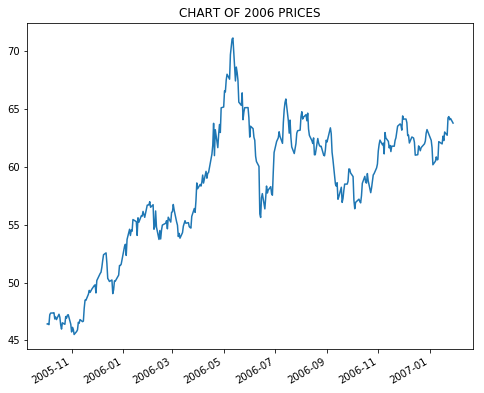

In [36]:
oct03_2005 = int(df[df['Date'] == '2005-10-03'].index.values)
jan30_2007 = int(df[df['Date'] == '2007-01-30'].index.values)

fig, ax = plt.subplots(figsize=(8, 6))

d = df['Date'][oct03_2005:jan30_2007]
e = df['Close'][oct03_2005:jan30_2007]

plt.xticks(rotation = 30, ha = 'right')
plt.plot(d, e)
plt.title('CHART OF 2006 PRICES');

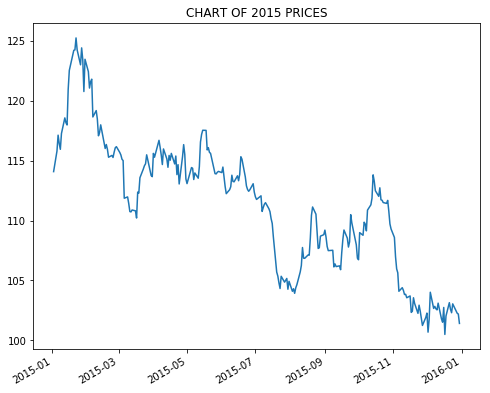

In [37]:
first_2015 = int(df[df['Date'] == '2015-01-02'].index.values)
last_2015 = int(df[df['Date'] == '2015-12-31'].index.values)

fig, ax = plt.subplots(figsize=(8, 6))

s = df['Date'][first_2015:last_2015]
t = df['Close'][first_2015:last_2015]

plt.xticks(rotation = 30, ha = 'right')
ax.plot(s, t)
plt.title('CHART OF 2015 PRICES');

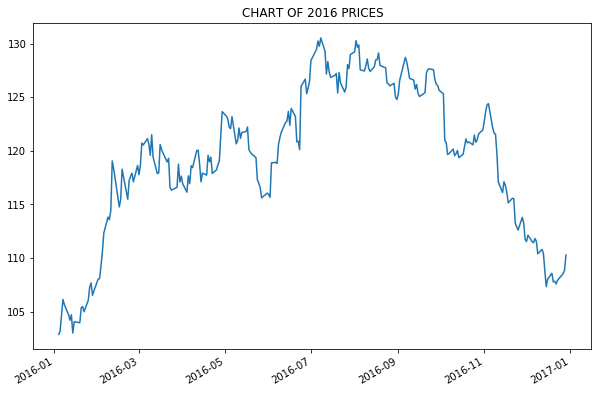

In [38]:
first_2016 = int(df[df['Date'] == '2016-01-04'].index.values)
last_2016 = int(df[df['Date'] == '2016-12-30'].index.values)

d = df['Date'][first_2016:last_2016]
e = df['Close'][first_2016:last_2016]

fig, ax = plt.subplots(figsize=(10, 6))

plt.xticks(rotation = 30, ha = 'right')
ax.plot(d, e)
plt.title('CHART OF 2016 PRICES');

#### The charts below show basing pattern examples.

#### The first charts shows that in late 2015 there was a short but important period for base formation that eventually proved to be a multi-year low.

Note that the real buy at that time was gold shares, much moreso than gold itself.  Sometime in 2015 or 2016, in a newsletter to shareholders, John Hathaway aptly pointed out that gold mining shares had been "carpet bombed" and were poised to rise substantially.

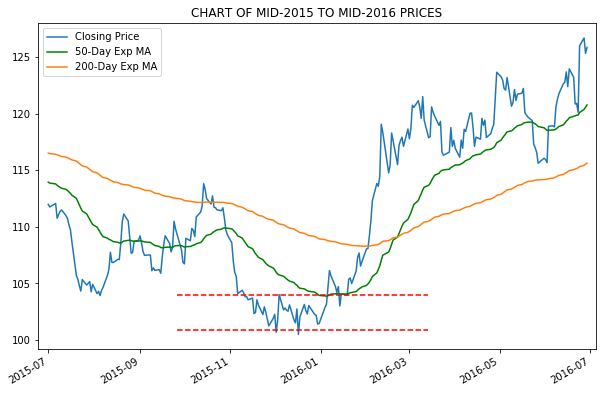

In [39]:
mid_2015 = int(df[df['Date'] == '2015-07-01'].index.values)
mid_2016 = int(df[df['Date'] == '2016-06-30'].index.values)
x_min = int(df[df['Date'] == '2015-06-24'].index.values)
x_max = int(df[df['Date'] == '2016-07-05'].index.values)
upper_bound = 104

d = df['Date'][mid_2015:mid_2016]
e = df['Close'][mid_2015:mid_2016]
f = df['50_day_exp_MA'][mid_2015:mid_2016]
g = df['200_day_exp_MA'][mid_2015:mid_2016]

fig, ax = plt.subplots(figsize=(10, 6))

plt.xlim(df['Date'][x_min], df['Date'][x_max])
plt.xticks(rotation = 30, ha = 'right')
ax.plot(d, e)
ax.plot(d, f, color='green')
ax.plot(d, g)
plt.axhline(y=upper_bound, xmin=0.25, xmax=0.7, color='red', linestyle='--')
plt.axhline(y=upper_bound*0.97, xmin=0.25, xmax=0.7, color='red', linestyle='--')
plt.title('CHART OF MID-2015 TO MID-2016 PRICES')
plt.legend(['Closing Price', '50-Day Exp MA', '200-Day Exp MA']);

In [41]:
dec21_2015 = int(df[df['Date'] == '2015-12-21'].index.values)
dec30_2015 = int(df[df['Date'] == '2015-12-30'].index.values)
df[dec21_2015:dec30_2015]  # all values in 'base' column show 'basing_pattern'

,Date,High,Low,Open,Close,Volume,Adj Close,Year,intercept,four_wk_change,...,day_range,day_range_perc,market_type,two_wk_forward_change,five_wk_forward_change,five_wk_forward_category,two_and_five_wk,25_day_min,25_day_max,base
2791,2015-12-21,103.519997,102.830002,102.949997,103.150002,6378900,103.150002,2015,1,0.060005,...,0.689995,0.006702,bull,0.014736,0.032865,no_major_change,1,100.5,104.019997,basing_pattern
2792,2015-12-22,103.199997,102.559998,103.089996,102.610001,4123500,102.610001,2015,1,0.349998,...,0.639999,0.006208,bull,0.034500,0.042296,no_major_change,1,100.5,104.019997,basing_pattern
2793,2015-12-23,102.589996,102.209999,102.400002,102.309998,2821400,102.309998,2015,1,-0.630005,...,0.379997,0.003711,bull,0.032939,0.056104,5_plus_perc_incr,1,100.5,104.019997,basing_pattern
2794,2015-12-24,103.050003,102.769997,102.820000,103.050003,1710200,103.050003,2015,1,0.590004,...,0.280006,0.002723,bull,0.016400,0.048908,no_major_change,1,100.5,104.019997,basing_pattern
2795,2015-12-28,102.599998,102.029999,102.480003,102.269997,3356200,102.269997,2015,1,1.019997,...,0.570000,0.005562,bull,0.018969,0.068251,5_plus_perc_incr,1,100.5,104.019997,basing_pattern
2796,2015-12-29,102.580002,102.110001,102.519997,102.199997,2832200,102.199997,2015,1,0.279999,...,0.470001,0.004584,bull,0.024658,0.081898,5_plus_perc_incr,1,100.5,104.019997,basing_pattern


#### Let's check to see if the run up in late 2007 and early 2008 was preceeded by a basing pattern.

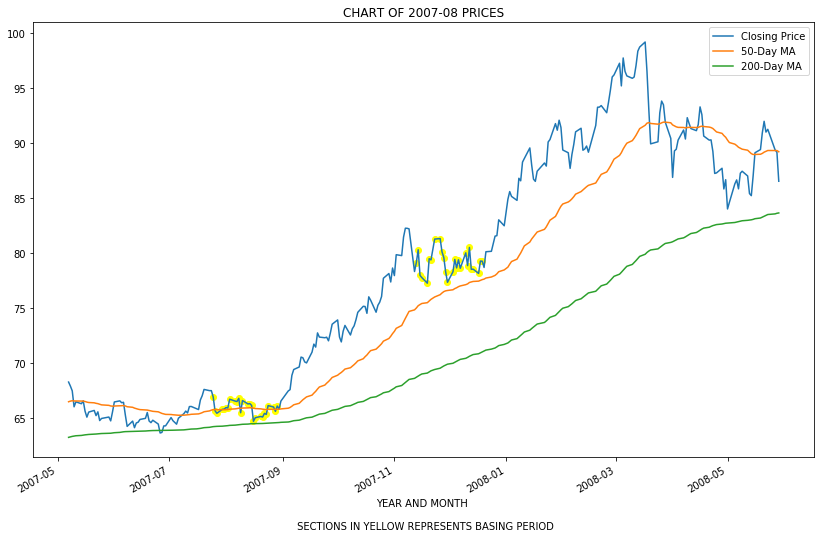

In [42]:
mid_2007 = int(df[df['Date'] == '2007-05-07'].index.values)
mid_2008 = int(df[df['Date'] == '2008-05-30'].index.values)
aug29_2007 = int(df[df['Date'] == '2007-08-29'].index.values)
dec19_2007 = int(df[df['Date'] == '2007-12-19'].index.values)

d = df['Date'][mid_2007:mid_2008]
e = df['Close'][mid_2007:mid_2008]
f = df['50_day_exp_MA'][mid_2007:mid_2008]
g = df['200_day_exp_MA'][mid_2007:mid_2008]

fig, ax = plt.subplots(figsize=(14, 8))

plt.xticks(rotation = 30, ha = 'right')
for i in range(0, 26):
    a = plt.scatter(df['Date'][aug29_2007-i], df['Close'][aug29_2007-i], color='yellow')
for i in range(0, 26):
    b = plt.scatter(df['Date'][dec19_2007-i], df['Close'][dec19_2007-i], color='yellow')

ax.plot(d, e)
ax.plot(d, f)
ax.plot(d, g)

plt.xlabel('YEAR AND MONTH \n\n SECTIONS IN YELLOW REPRESENTS BASING PERIOD')
ax.legend(['Closing Price', '50-Day MA', '200-Day MA'])
plt.title('CHART OF 2007-08 PRICES');

In [43]:
aug24_2007 = int(df[df['Date'] == '2007-08-24'].index.values)
aug31_2007 = int(df[df['Date'] == '2007-08-31'].index.values)
df[aug24_2007:aug31_2007]

,Date,High,Low,Open,Close,Volume,Adj Close,Year,intercept,four_wk_change,...,day_range,day_range_perc,market_type,two_wk_forward_change,five_wk_forward_change,five_wk_forward_category,two_and_five_wk,25_day_min,25_day_max,base
695,2007-08-24,66.209999,65.309998,65.419998,66.110001,3648300,66.110001,2007,1,0.699997,...,0.900002,0.013757,bull,0.053093,0.117834,5_plus_perc_incr,1,64.68,67.580002,basing_pattern
696,2007-08-27,66.050003,65.860001,66.010002,65.980003,1865700,65.980003,2007,1,0.210007,...,0.190002,0.002878,bull,0.068809,0.096544,5_plus_perc_incr,1,64.68,67.470001,basing_pattern
697,2007-08-28,66.099998,65.480003,65.949997,65.589996,3473100,65.589996,2007,1,-0.200005,...,0.619995,0.009401,bull,0.074249,0.096204,5_plus_perc_incr,1,64.68,67.470001,basing_pattern
698,2007-08-29,66.199997,65.730003,65.889999,66.070000,4469800,66.070000,2007,1,0.139999,...,0.469994,0.007133,bull,0.060693,0.102921,5_plus_perc_incr,1,64.68,66.900002,basing_pattern
699,2007-08-30,66.099998,65.629997,65.870003,65.800003,3027700,65.800003,2007,1,-0.089996,...,0.470001,0.007135,bull,0.063678,0.115501,5_plus_perc_incr,1,64.68,66.769997,basing_pattern


In [44]:
def upper_trend(x):
    y = -0.075*x + 127.2
    return y

upper_trend_line = []
for i in range(0, 73):
    a = upper_trend(i)
    upper_trend_line.append(a)

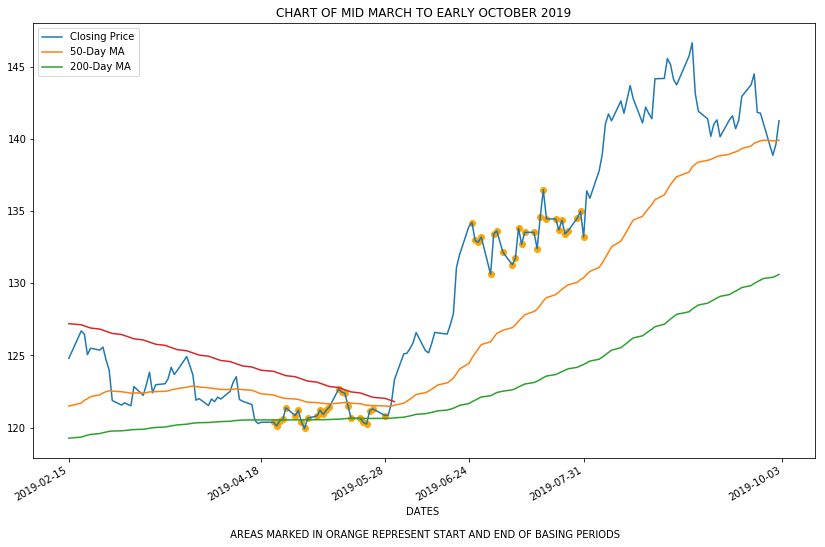

In [46]:
feb15_2019 = int(df[df['Date'] == '2019-02-15'].index.values)
may28_2019 = int(df[df['Date'] == '2019-05-28'].index.values)
july31_2019 = int(df[df['Date'] == '2019-07-31'].index.values)
oct03_2019 = int(df[df['Date'] == '2019-10-03'].index.values)

d = df['Date'][feb15_2019:oct03_2019]
d_trend_line = df['Date'][feb15_2019:feb15_2019+73]
e = df['Close'][feb15_2019:oct03_2019]
f = df['50_day_exp_MA'][feb15_2019:oct03_2019]
g = df['200_day_exp_MA'][feb15_2019:oct03_2019]

fig, ax = plt.subplots(figsize=(14, 8))

x_ticks = [df['Date'].dt.date[feb15_2019], df['Date'].dt.date[may28_2019-26],
           df['Date'].dt.date[may28_2019], df['Date'].dt.date[july31_2019-26], 
           df['Date'].dt.date[july31_2019], df['Date'].dt.date[oct03_2019]]
plt.xticks(x_ticks, x_ticks, rotation=30, ha="right")
ax.plot(d, e)
ax.plot(d, f)
ax.plot(d, g)
ax.plot(d_trend_line, upper_trend_line)
for i in range(0, 26):
    plt.scatter(df['Date'][may28_2019-i], df['Close'][may28_2019-i], color='orange')
for i in range(0, 26):
    plt.scatter(df['Date'][july31_2019-i], df['Close'][july31_2019-i], color='orange')

plt.xlabel('DATES \n\n AREAS MARKED IN ORANGE REPRESENT START AND END OF BASING PERIODS')
plt.title('CHART OF MID MARCH TO EARLY OCTOBER 2019')
ax.legend(['Closing Price', '50-Day MA', '200-Day MA']);

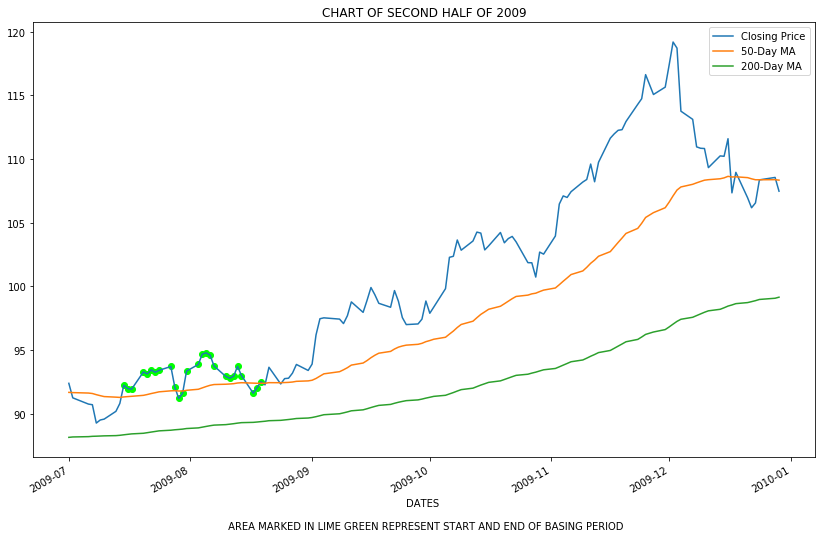

In [47]:
july01_2009 = int(df[df['Date'] == '2009-07-01'].index.values)
dec30_2009 = int(df[df['Date'] == '2009-12-30'].index.values)
aug19_2009 = int(df[df['Date'] == '2009-08-19'].index.values)
aug27_2009  = int(df[df['Date'] == '2009-08-27'].index.values)

d = df['Date'][july01_2009:dec30_2009]
e = df['Close'][july01_2009:dec30_2009]
f = df['50_day_exp_MA'][july01_2009:dec30_2009]
g = df['200_day_exp_MA'][july01_2009:dec30_2009]

fig, ax = plt.subplots(figsize=(14, 8))

plt.xticks(rotation=30, ha="right")
ax.plot(d, e)
ax.plot(d, f)
ax.plot(d, g)
for i in range(0, 26):
    plt.scatter(df['Date'][aug19_2009-i], df['Close'][aug19_2009-i], color='lime')

plt.xlabel('DATES \n\n AREA MARKED IN LIME GREEN REPRESENT START AND END OF BASING PERIOD')
plt.title('CHART OF SECOND HALF OF 2009')
ax.legend(['Closing Price', '50-Day MA', '200-Day MA']);

In [48]:
df[aug19_2009:aug27_2009]

,Date,High,Low,Open,Close,Volume,Adj Close,Year,intercept,four_wk_change,...,day_range,day_range_perc,market_type,two_wk_forward_change,five_wk_forward_change,five_wk_forward_category,two_and_five_wk,25_day_min,25_day_max,base
1195,2009-08-19,92.779999,91.660004,91.680000,92.529999,7119800,92.529999,2009,1,-0.910004,...,1.119995,0.012216,bull,0.039555,0.054253,5_plus_perc_incr,1,91.199997,94.779999,basing_pattern
1196,2009-08-20,92.550003,92.120003,92.309998,92.269997,3973000,92.269997,2009,1,-0.990005,...,0.430000,0.004658,bull,0.056248,0.051263,5_plus_perc_incr,1,91.199997,94.779999,basing_pattern
1197,2009-08-21,93.800003,93.400002,93.629997,93.650002,7285300,93.650002,2009,1,0.239998,...,0.400002,0.004272,bull,0.041431,0.036305,no_major_change,1,91.199997,94.779999,basing_pattern
1198,2009-08-24,93.699997,91.639999,93.639999,92.339996,8548000,92.339996,2009,1,-1.370003,...,2.059998,0.021999,bull,0.055122,0.055122,5_plus_perc_incr,1,91.199997,94.779999,basing_pattern
1199,2009-08-25,93.459999,92.489998,93.400002,92.760002,8280500,92.760002,2009,1,0.650002,...,0.970001,0.010385,bull,0.046572,0.065653,5_plus_perc_incr,1,91.199997,94.779999,basing_pattern
1200,2009-08-26,92.849998,92.209999,92.669998,92.790001,5224300,92.790001,2009,1,1.590004,...,0.639999,0.006906,bull,0.052915,0.054963,5_plus_perc_incr,1,91.199997,94.779999,basing_pattern


#### In general, what does the view of basing patterns and five week forward prices look like?

In [49]:
df.groupby(['market_type', 'base', 'five_wk_forward_category'])['intercept'].sum()

market_type  base                   five_wk_forward_category
bear         basing_pattern         5_plus_perc_drop              49
                                    5_plus_perc_incr              18
                                    no_major_change              106
             not_in_basing_pattern  5_plus_perc_drop             182
                                    5_plus_perc_incr             123
                                    no_major_change              609
bull         basing_pattern         5_plus_perc_drop              15
                                    5_plus_perc_incr              93
                                    no_major_change              337
             not_in_basing_pattern  5_plus_perc_drop             180
                                    5_plus_perc_incr             587
                                    no_major_change             1459
Name: intercept, dtype: int64

#### Conclusions: 

- In a bull market there are relatively few cases where there was a major drop from a time when the price was in a basing pattern.
- Some large rallies came after a basing pattern.

- Overall, however, many of the large gains came during periods when the price was NOT in a basing pattern.

- The run ups shown above have not been quantified precisely but they are in the range of around 12% or so over a relatively short time period, such as one to three months

## Current Situation

#### displayed are the most recent 10 trading days and also the single most recent trading day

In [50]:
df.tail(10)

,Date,High,Low,Open,Close,Volume,Adj Close,Year,intercept,four_wk_change,...,day_range,day_range_perc,market_type,two_wk_forward_change,five_wk_forward_change,five_wk_forward_category,two_and_five_wk,25_day_min,25_day_max,base
3773,2019-11-14,138.940002,137.869995,138.389999,138.559998,5220500,138.559998,2019,1,-2.050003,...,1.070007,0.007732,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,basing_pattern
3774,2019-11-15,138.419998,137.970001,138.029999,138.210007,10106700,138.210007,2019,1,-2.250000,...,0.449997,0.003260,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,not_in_basing_pattern
3775,2019-11-18,138.850006,138.300003,138.440002,138.619995,5717900,138.619995,2019,1,-1.169998,...,0.550003,0.003973,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,basing_pattern
3776,2019-11-19,138.970001,138.130005,138.130005,138.690002,4824400,138.690002,2019,1,-1.509995,...,0.839996,0.006081,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,basing_pattern
3777,2019-11-20,139.000000,138.100006,138.529999,138.759995,6892100,138.759995,2019,1,-1.770004,...,0.899994,0.006497,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,basing_pattern
3778,2019-11-21,138.559998,137.770004,138.389999,138.000000,4197200,138.000000,2019,1,-3.529999,...,0.789993,0.005708,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,not_in_basing_pattern
3779,2019-11-22,138.460007,137.660004,138.369995,137.740005,3620300,137.740005,2019,1,-4.119995,...,0.800003,0.005782,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,not_in_basing_pattern
3780,2019-11-25,137.619995,136.990005,137.320007,137.080002,6415800,137.080002,2019,1,-3.559998,...,0.629990,0.004588,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,not_in_basing_pattern
3781,2019-11-26,137.800003,136.580002,136.979996,137.740005,4724400,137.740005,2019,1,-2.509995,...,1.220001,0.008906,bull,NaN,NaN,no_major_change,0,137.059998,142.559998,not_in_basing_pattern
3782,2019-11-27,137.210007,136.830002,137.029999,137.009995,4111000,137.009995,2019,1,-4.010010,...,0.380005,0.002773,bull,NaN,NaN,no_major_change,0,137.009995,142.559998,not_in_basing_pattern


In [53]:
last_row = df.shape[0]-1
df.iloc[last_row]

Date                          2019-11-27 00:00:00
High                                       137.21
Low                                        136.83
Open                                       137.03
Close                                      137.01
Volume                                    4111000
Adj Close                                  137.01
Year                                         2019
intercept                                       1
four_wk_change                           -4.01001
four_wk_perc_change                    -0.0284358
past_four_weeks                   no_major_change
fifteen_wk_perc_change                 -0.0336437
rolling_52_wk_high                         146.66
rolling_52_wk_low                          114.77
52_wk_status                    not_near_high_low
rolling_4_wk_high                          142.56
rolling_4_wk_low                           137.01
4_wk_status                      at_near_4_wk_low
10_day_simple_MA                          138.041


#### let's take a look at whether or not the there is a substantial difference in performance when looking at the fifty_to_ten column

In [55]:
df.groupby('fifty_to_ten')['two_wk_forward_change'].describe()

,count,mean,std,min,25%,50%,75%,max
fifty_to_ten,,,,,,,,
fifty_day_above_10,1601.0,0.004420,0.034896,-0.151031,-0.014397,0.003313,0.024658,0.182950
ten_day_above_exp_50,2172.0,0.003012,0.036084,-0.214127,-0.019435,0.003245,0.024660,0.135838


#### next we will look specifically at the inflection / crossover points and how prices performed in the subsequent trading days

In [62]:
df['fifty_to_ten_comp'] = df['fifty_to_ten'] == df['fifty_to_ten'].shift()

In [65]:
df.groupby('fifty_to_ten_comp')['two_wk_forward_change'].describe()

,count,mean,std,min,25%,50%,75%,max
fifty_to_ten_comp,,,,,,,,
False,112.0,0.002553,0.032213,-0.105968,-0.01420,0.006876,0.020432,0.066897
True,3661.0,0.003642,0.035689,-0.214127,-0.01768,0.003180,0.024706,0.182950


In [66]:
df.groupby('fifty_to_ten_comp')['five_wk_forward_change'].describe()

,count,mean,std,min,25%,50%,75%,max
fifty_to_ten_comp,,,,,,,,
False,111.0,0.005669,0.049135,-0.146581,-0.020431,-0.001123,0.038109,0.122804
True,3647.0,0.009225,0.055228,-0.217177,-0.024179,0.005658,0.044199,0.225718


#### below is a view of five-week changes in relation to whether or not GLD was near a 52-week high or low

In [67]:
df.groupby(['52_wk_status', 'five_wk_forward_category'])['intercept'].sum().unstack()

five_wk_forward_category,5_plus_perc_drop,5_plus_perc_incr,no_major_change
52_wk_status,,,
at_near_52_wk_high,64,245,538
at_near_52_wk_low,48,54,291
not_near_high_low,322,522,1699


## Recent Trades Executed

Put Option Income: USD $73


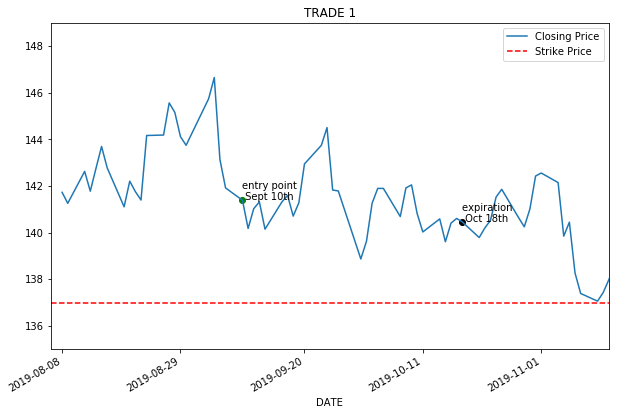

In [62]:
aug08_2019 = int(df[df['Date'] == '2019-08-08'].index.values)
sept09_2019 = int(df[df['Date'] == '2019-09-09'].index.values)
oct18_2019 = int(df[df['Date'] == '2019-10-18'].index.values)

d = df['Date'][aug08_2019:aug08_2019+75]
e = df['Close'][aug08_2019:aug08_2019+75]

fig, ax = plt.subplots(figsize=(10, 6))

x_dates = []
for i in np.arange(0, 75, 15):
    a = df['Date'].dt.date[aug08_2019+i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation = 30, ha = 'right')
plt.xlim(df['Date'][aug08_2019-2], df['Date'][oct18_2019+18])
plt.ylim(135, 149)

ax.scatter(df['Date'][sept09_2019], df['Close'][sept09_2019], color='green')
ax.scatter(df['Date'][oct18_2019], df['Close'][oct18_2019], color='black')
ax.annotate('entry point \n Sept 10th', (df['Date'][sept09_2019], df['Close'][sept09_2019]))
ax.annotate('expiration \n Oct 18th', (df['Date'][oct18_2019], df['Close'][oct18_2019]))

ax.plot(d, e)
plt.axhline(y=137, color='red', linestyle='--')

plt.xlabel('DATE')
plt.title('TRADE 1')
plt.legend(['Closing Price', 'Strike Price'])
print('Put Option Income: USD $73');

In [84]:
num_days = 84
slope = -.10

def trend_channel(x):
    y1 = slope*x + 149
    y2 = slope*x + 143.25
    return y1, y2

trend = []
for i in range(0, num_days):
    a = trend_channel(i)
    trend.append(a)

Put Option Income: USD $41


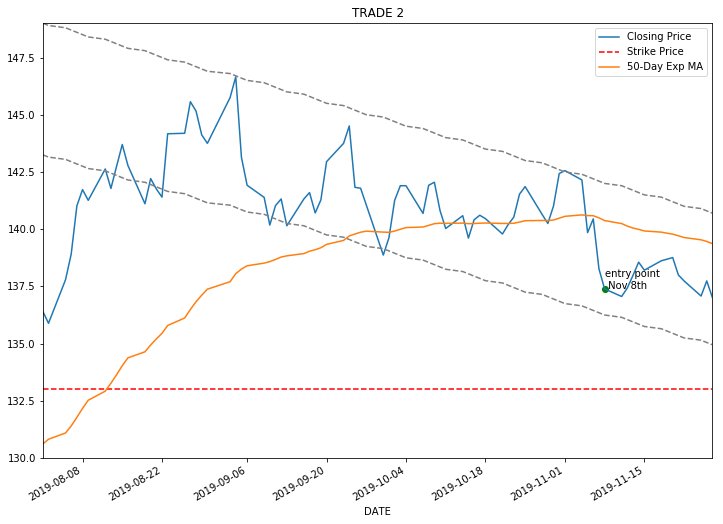

In [85]:
aug01_2019 = int(df[df['Date'] == '2019-08-01'].index.values)
nov08_2019 = int(df[df['Date'] == '2019-11-08'].index.values)
#dec20_2019 = int(df[df['Date'] == '2019-12-20'].index.values)

d = df['Date'][aug01_2019:aug01_2019+num_days]
e = df['Close'][aug01_2019:aug01_2019+num_days]
f = df['50_day_exp_MA'][aug01_2019:aug01_2019+num_days]
g = df['200_day_exp_MA'][aug01_2019:aug01_2019+num_days]

fig, ax = plt.subplots(figsize=(12, 8))

x_dates = []
for i in np.arange(5, 80, 10):
    a = df['Date'].dt.date[aug01_2019+i]
    x_dates.append(a)

plt.xticks(x_dates, x_dates, rotation = 30, ha = 'right')
plt.xlim(df['Date'][aug01_2019], df['Date'][aug01_2019+num_days-1])
plt.ylim(130, 149)

ax.scatter(df['Date'][nov08_2019], df['Close'][nov08_2019], color='green')
ax.annotate('entry point \n Nov 8th', (df['Date'][nov08_2019], df['Close'][nov08_2019]))
# ax.scatter(df['Date'][dec20_2019], df['Close'][dec20_2019], color='black')

ax.plot(d, e)
plt.axhline(y=133, color='red', linestyle='--')
ax.plot(d, f)
ax.plot(d, trend, linestyle='--', color='grey')
# ax.plot(d, g)

plt.xlabel('DATE')
plt.title('TRADE 2')
plt.legend(['Closing Price', 'Strike Price', '50-Day Exp MA'])
print('Put Option Income: USD $41');